In [17]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import os
import sys

from importlib import reload

sys.path.append('')
import deck_load

import inspect

import warnings
warnings.filterwarnings("ignore")
import plot_type

In [4]:
import intake

In [5]:
deck_load = reload(deck_load)
#  institution, model, ensemble,variable

In [8]:
ipsl = deck_load.Deck('IPSL','IPSL-CM6A-LR','r1i1p1f1','ts')

In [9]:
ipsl

DECK data for IPSL IPSL-CM6A-LR 
**** ENS: r1i1p1f1 
**** VAR: ts

 --------------- 

Summary of: self.data
Coordinates:
  * time      (time) object 1850-01-16 12:00:00 ... 3849-12-16 12:00:00
  * lat       (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon       (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'
Var: ts


In [13]:
# The anomalies based upon the 1850 to 1900 climatology,
ipsl_anom = ipsl.anomalies()
ipsl_anom

Weighted Space mean of DECK data for IPSL IPSL-CM6A-LR 
**** ENS: r1i1p1f1 
**** VAR: ts
Time frame: 1850 - 3849


In [143]:
ipsl_anom_smean.time.values[:5]

array([cftime.DatetimeGregorian(1850, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1851, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1852, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1853, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1854, 12, 31, 0, 0, 0, 0)], dtype=object)

In [15]:
# The space mean of the anomaies (smean)
ipsl_anom_smean = ipsl_anom.space_mean()
ipsl_anom_smean

<xarray.DataArray 'ts' (scenario: 4, time: 2000)>
dask.array<truediv, shape=(4, 2000), dtype=float32, chunksize=(1, 8), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 3849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [25]:
# PUtting the space mean anomalies into memory, so each time I use the data it doesn't have to be
# recalcualted.
ipsl_anom_smean = ipsl_anom_smean.compute()

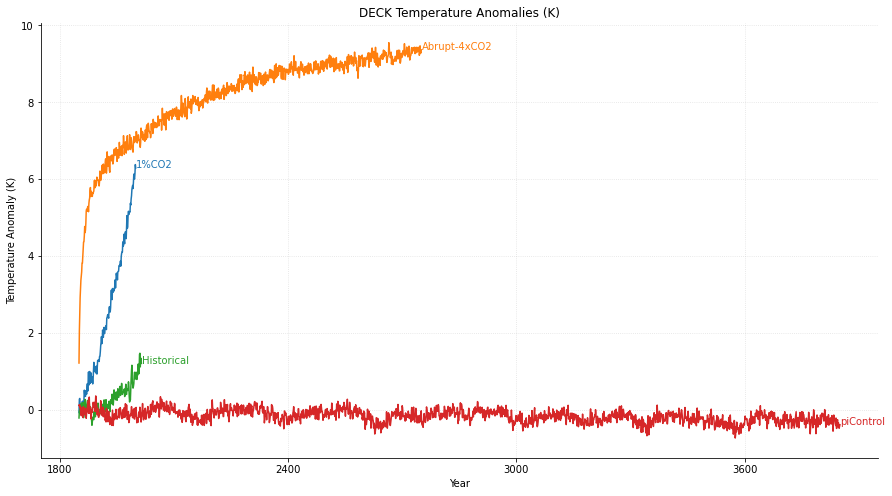

In [19]:
plot_type = reload(plot_type)

data = ipsl_anom_smean

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Anomaly (K)')
ax.grid(alpha = 0.4, linestyle = ':')

In [28]:
ipsl_anom_smean = ipsl_anom_smean.isel(time = slice(None, 1000))

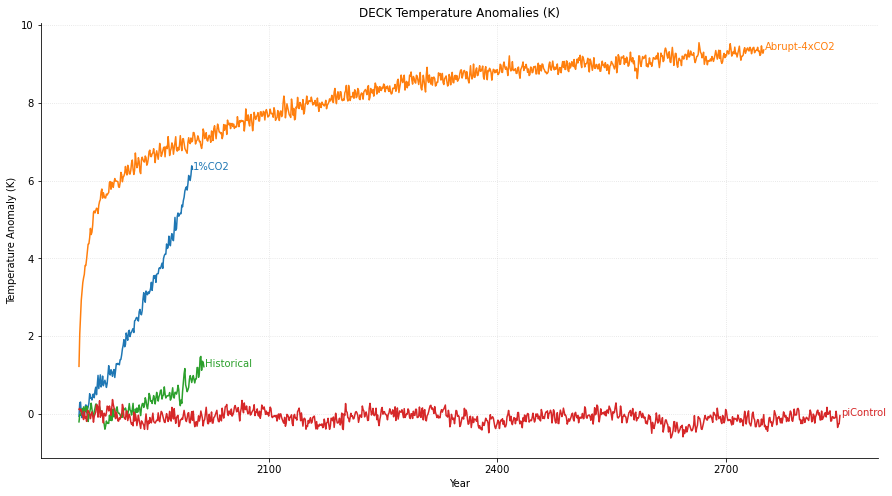

In [29]:
plot_type = reload(plot_type)

data = ipsl_anom_smean

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Anomaly (K)')
ax.grid(alpha = 0.4, linestyle = ':')

## Signal

In [91]:
def grid_trend(x, use = [0][0]):
    # Use = [0][0] will just return the gradient
    # USe  = [0,1] will return the gradient and y-intercept.
    
    if all(~np.isfinite(x)):
        return np.nan
    
    # If every point is just a nan values. We don't want to do the polyfit calculation. Just return nan
    t = np.arange(len(x))

    # Getting the gradient of a linear interpolation
    idx = np.isfinite(x) #checking where the nans.
    x = x[idx]
    t = t[idx]
    
    if len(x) < 3:
        return np.nan
    
    poly = np.polyfit(t,x,1)
    
    return poly[use]

In [92]:
grid_trend(np.array([0,1,2,3,4,5]), use = [0][0])

0.9999999999999998

In [106]:
ipsl_1pct = \
                ipsl_anom_smean.sel(scenario = '1pctCO2').where(
                np.isfinite(ipsl_anom_smean.sel(scenario = '1pctCO2')), 
                                                drop = True)

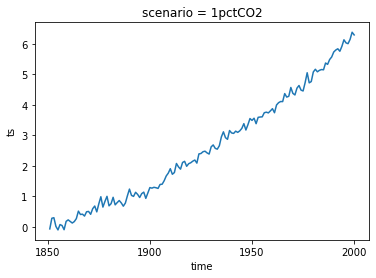

In [108]:
ipsl_1pct.plot()

In [109]:
grid_trend(ipsl_1pct.values)

0.04175485178065432

In [93]:
def trend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(grid_trend, axis[0], arr)

In [94]:
ROLL_PERIOD = 61

In [95]:
ipsl_anom_smean.values.shape

(4, 1000)

In [98]:
ipsl_smean_signal = np.abs(ipsl_anom_smean.rolling(time = ROLL_PERIOD, center = True).reduce(trend_helper))
ipsl_smean_signal 

(4, 1000, 61) 2


<xarray.DataArray 'ts' (scenario: 4, time: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

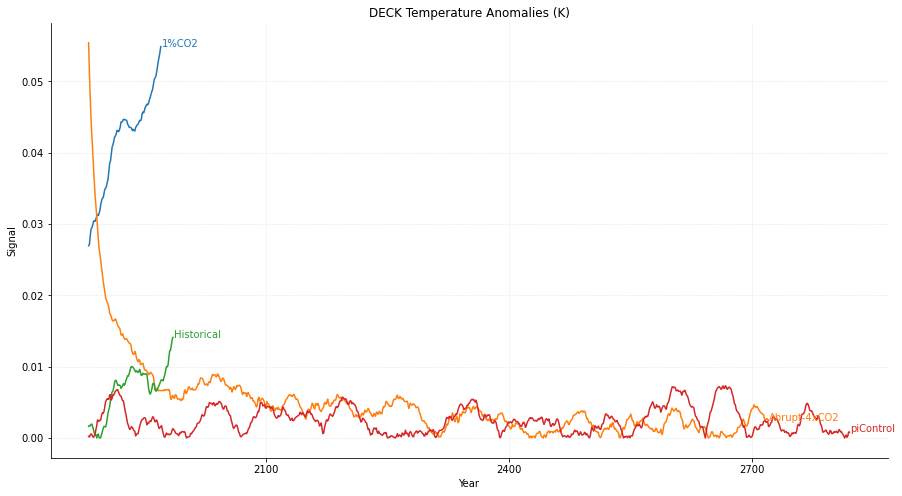

In [100]:
plot_type = reload(plot_type)

data = ipsl_smean_signal

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal')
ax.grid(alpha = 0.4, linestyle = ':')

## Noise

1.83 0.28


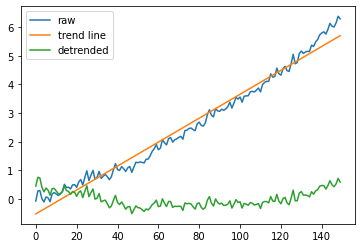

In [115]:
y = ipsl_1pct
x = np.arange(len(y))

# Getting the gradient of a linear interpolation
idy = np.isfinite(y) #checking where the nans.
y = y[idy]
x = x[idy]



m,c = np.polyfit(x,y,1)

trend_line = m * x + c

y_detrend = y - trend_line

plt.plot(y, label = 'raw')
plt.plot(trend_line, label = 'trend line')
plt.plot(y_detrend, label = 'detrended')

print(np.round(np.std(y.values),2), np.round(np.std(y_detrend.values),2))

plt.legend()

In [125]:
def grid_noise(y):
    x = np.arange(len(y))

    # Getting the gradient of a linear interpolation
    idy = np.isfinite(y) #checking where the nans.
    y = y[idy]
    x = x[idy]
    
    if len(y) < 10:
        return np.nan
    
    m,c = np.polyfit(x,y,1)

    trend_line = m * x + c

    y_detrend = y - trend_line

    std_detrend = np.std(y_detrend)
    
    return std_detrend

In [126]:
def std_detrend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(grid_noise, axis[0], arr)

In [127]:
ipsl_smean_noise = ipsl_anom_smean.rolling(time = ROLL_PERIOD, center = True).reduce(std_detrend_helper) ** 2
ipsl_smean_noise

(4, 1000, 61) 2


<xarray.DataArray 'ts' (scenario: 4, time: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

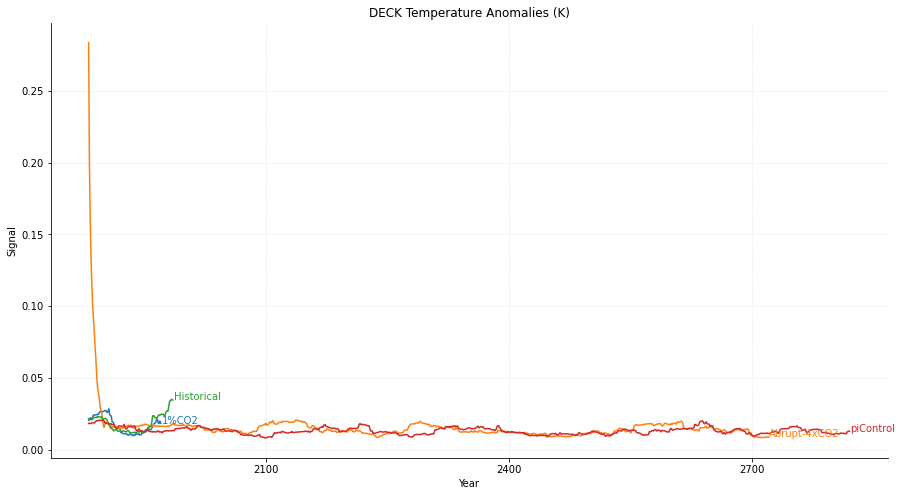

In [128]:
plot_type = reload(plot_type)

data = ipsl_smean_noise

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal')
ax.grid(alpha = 0.4, linestyle = ':')

In [129]:
ipsl_smean_sn = ipsl_smean_signal/ipsl_smean_noise
ipsl_smean_sn.coords

Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

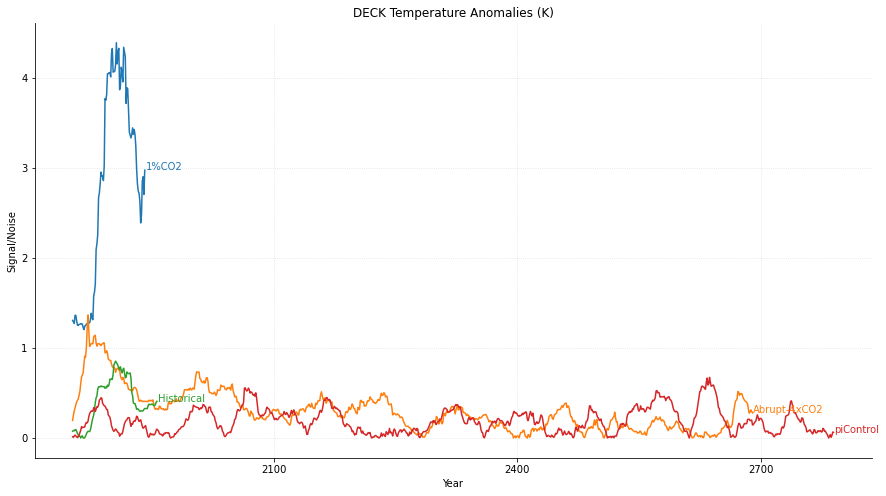

In [133]:
plot_type = reload(plot_type)

data = ipsl_smean_sn

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal/Noise')
ax.grid(alpha = 0.4, linestyle = ':')

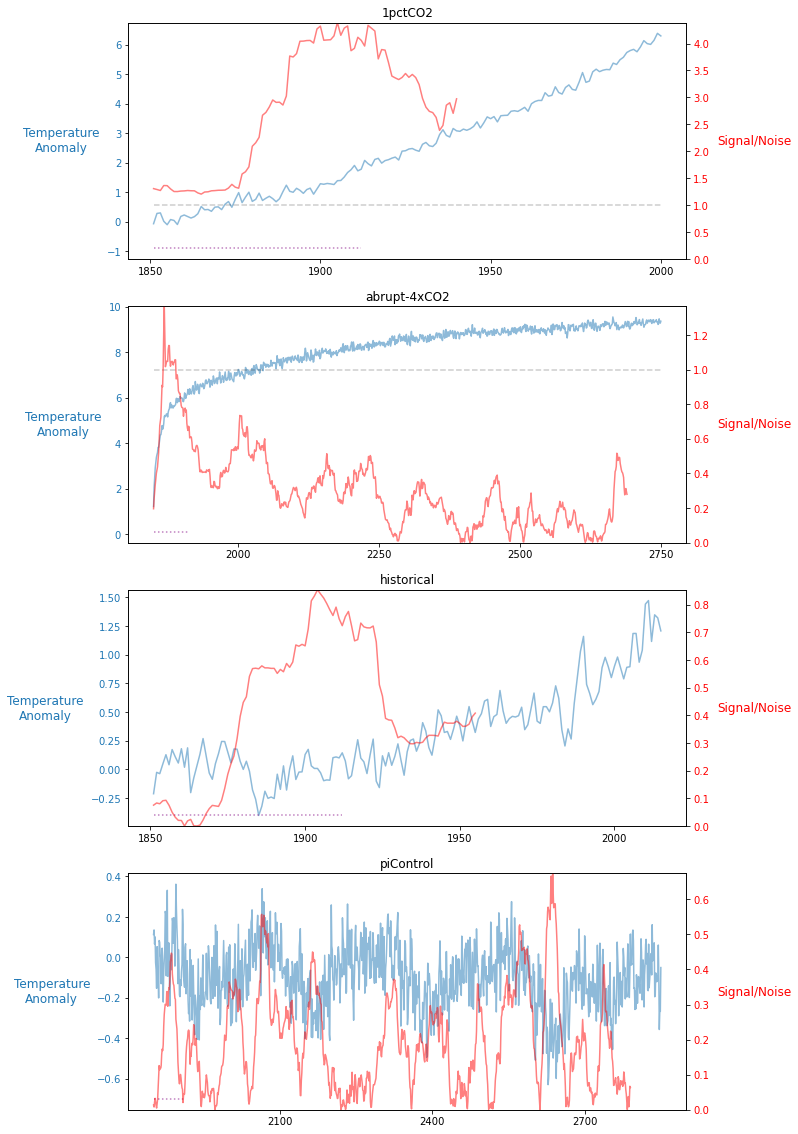

In [166]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(ipsl_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
    anom_data = ipsl_anom_smean.sel(scenario = scenario)
    sn_data = ipsl_smean_sn.sel(scenario = scenario)
    
    anom_data = anom_data.where(np.isfinite(anom_data), drop = True)
    sn_data = sn_data.where(np.isfinite(sn_data), drop = True)

    
    ax.plot(anom_data.time.values, anom_data.values, label = 'Temperature Anomalies', alpha = 0.5)
    c1 = plt.gca().lines[0].get_color()
    ax.tick_params(axis = 'y', labelcolor = c1)
    ax.set_ylabel('Temperature\nAnomaly', size = 12, color = c1, rotation = 0, labelpad = 45, va = 'center')
    
    ax.plot([anom_data.time.values[0], anom_data.time.values[0] + pd.to_timedelta(f'{ROLL_PERIOD }Y')],
       [ax.get_yticks()[0] + 0.1,ax.get_yticks()[0] + 0.1], color = 'purple', linestyle = ':', alpha = 0.5)

    ax2 = ax.twinx()

    ax2.plot(sn_data.time.values, sn_data.values, color = 'red', label = 'S/N', alpha = 0.5)
    c2 = plt.gca().lines[0].get_color()
    ax2.tick_params(axis = 'y', labelcolor = c2)
    ax2.set_ylabel('Signal/Noise', size = 12, color = c2, rotation = 0, labelpad = 45, va = 'center')
    
    ax2.set_ylim([0, np.max(sn_data.values)])

    ax2.plot([anom_data.time.values[0],anom_data.time.values[-1]], [1,1], color = 'k', linestyle = '--', alpha = .2,
            zorder = -1);
    

    
    ax.set_title(scenario)